# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
import operator
import math



Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
  # set number of examples
  labels, data = train_labels[:num_examples], train_data[:num_examples]
  
  # Iterate through and print labels and data
  for index, (cat, text) in enumerate(zip(labels, data)):
      print("Label {}: {}\n".format(index+1, newsgroups_train.target_names[cat]))
      print("Text {}: {}".format(index+1, text))
      print("\n\n")

P1(5)

Label 1: comp.graphics

Text 1: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych



Label 2: talk.religion.misc

Text 2: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for 

### Part 2:  
2.1  
Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

2.2  
Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

2.3  
Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

2.4  
Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

2.5  
Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [4]:
def P2():
    # 2.1
    print("2.1")
    # Word unigram matrix
    cv = CountVectorizer()
    cv_train_data = cv.fit_transform(train_data) # ngram_range default is (1,1), analyzer default is 'word'.
    rows = cv_train_data.shape[0] # number of examples
    cols = cv_train_data.shape[1] # size of vocabulary
    print("The size of the training vocabulary is: {}".format(cols))
    # average number of nonzero values per example 
    print("The average number of non-zero featrues per example is: {}".format(round(cv_train_data.nnz/rows, 2)))
    # fraction of nonzero entries in the matrix
    print("The fraction of the nonzero entries in the matrix is: {}".format(round(cv_train_data.nnz / (rows * cols), 5)))
    # What are the first and last feature strings
    print("The first and last feature strings are: '{}', '{}'".format(cv.get_feature_names()[0], cv.get_feature_names()[-1]))
    print("\n")

    # 2.2
    print("2.2")
    # Word unigram matrix using specified vocabulary
    cv = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
    cv_train_data = cv.transform(train_data)
    rows, cols = cv_train_data.shape[0], cv_train_data.shape[1]
    # Size of the vocabulary
    print("The size of the specified vocabulary is confirmed at: {}".format(cols))
    # average number of nonzero values per example 
    print("The average number of non-zero featrues per example is: {}".format(round(cv_train_data.nnz/rows, 2)))
    print("\n")

    # 2.3 - Character bigram and trigram matrix
    print("2.3")
    cv = CountVectorizer(analyzer="char", ngram_range=(2,3)) # character bigram and trigram
    cv_train_data = cv.fit_transform(train_data)
    rows, cols = cv_train_data.shape[0], cv_train_data.shape[1]  # num examples, num words
    # Size of the vocabulary
    print("The size of the vocabulary after creating a bigram and trigam char matrix is: {}".format(cols))
    print("\n")
    
    # 2.4 
    print("2.4")
    # Prune words that appear in fewer than 10 documents
    cv = CountVectorizer(min_df=10) # min_df ignores words that have a document frequency strcitly lower than the given threshold
    cv_train_data = cv.fit_transform(train_data)
    rows, cols = cv_train_data.shape[0], cv_train_data.shape[1]
    # Size of the vocabulary
    print("The size of the training vocabulary after pruning words that appear in fewer than 10 documents is: {}".format(cols))
    print("\n")

    # 2.5
    print("2.5")
    # Build training vocabulary
    cv_train = CountVectorizer()
    cv_train.fit_transform(train_data)
    vocab_train = cv_train.get_feature_names()
    # Build development vocabulary
    cv_dev = CountVectorizer()
    cv_dev.fit_transform(dev_data)
    vocab_dev = cv_dev.get_feature_names()
    # Find the words common to each vocabulary
    vocab_common = set(vocab_dev) & set(vocab_train)
    # Missing = total length - common
    vocab_missing = len(vocab_dev)-len(vocab_common)
    print("The fraction of words in the development vocabulary that are missing from the training vocabulary is: {}".format(round(vocab_missing/len(vocab_dev), 2)))

P2()

2.1
The size of the training vocabulary is: 26879
The average number of non-zero featrues per example is: 96.71
The fraction of the nonzero entries in the matrix is: 0.0036
The first and last feature strings are: '00', 'zyxel'


2.2
The size of the specified vocabulary is confirmed at: 4
The average number of non-zero featrues per example is: 0.27


2.3
The size of the vocabulary after creating a bigram and trigam char matrix is: 35478


2.4
The size of the training vocabulary after pruning words that appear in fewer than 10 documents is: 3064


2.5
The fraction of words in the development vocabulary that are missing from the training vocabulary is: 0.25


#### Most common features:

In [5]:
cvt = CountVectorizer()
cv_train_data = cvt.fit_transform(train_data)

counts = pd.DataFrame(cv_train_data.toarray(), columns=cvt.get_feature_names())

display(counts.sum().sort_values(ascending=False).head(20))

the     19159
to      10000
of       9931
and      8233
is       6551
in       5764
that     5602
it       4589
for      3950
you      3765
this     2833
be       2792
on       2687
are      2683
not      2608
as       2412
have     2340
or       2104
with     2049
but      1861
dtype: int64

#### Visualize CountVectorizer Matrix:

In [6]:
counts.T.sort_values(by=0, ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,...,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
the,7,1,1,11,1,4,2,10,1,1,...,31,13,2,0,13,3,2,0,4,0
file,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
to,4,4,2,14,2,3,1,3,1,3,...,4,8,3,0,10,0,1,2,4,0
3ds,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
is,3,0,0,2,0,1,2,3,1,2,...,12,2,0,0,2,0,0,0,10,0
in,3,0,1,2,0,2,2,1,1,3,...,4,3,0,0,1,0,0,0,3,0
prj,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
you,3,0,0,5,0,2,1,1,0,0,...,1,5,0,0,3,0,0,2,7,0
anyone,2,0,0,1,2,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
are,2,0,0,0,0,2,1,1,0,0,...,0,2,0,0,1,0,0,0,0,0


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [7]:
def P3():
  # 3.1
  print("Part 3.1")
  # Convert a collection of text documents to a matrix of token counts
  cv = CountVectorizer()
  # Training and development word unigram feature vectors
  cv_train_data, cv_dev_data = cv.fit_transform(train_data) , cv.transform(dev_data)
  # Create dictionary
  knn_score_dict = {}
  # Iterate through different k-NN models
  # Store k vaule and f1-score in dictionary
  print("k-NN Model Results:")
  k_list = [10,20,30,40,50,60,70,80,90,100, 110]
  for k in k_list:
      knn_model = KNeighborsClassifier(n_neighbors=k) # Set k-NN classifier with k value
      knn_model.fit(cv_train_data, train_labels) # fit the model
      knn_score = knn_model.score(cv_dev_data, dev_labels) # score the model (not used)
      knn_predictions = knn_model.predict(cv_dev_data) # generate predictions
      knn_f1_score = metrics.f1_score(dev_labels, knn_predictions, average='weighted') # calculate the f1-score
      knn_score_dict[k]=knn_f1_score # Store values in dictionary
      print("k = {:2d} has f1-score: {}".format(k, round(knn_f1_score, 4)))

  # Get max score and respective k value
  k_max, score_max = max(knn_score_dict.items(), key=operator.itemgetter(1))[0], \
                      round(max(knn_score_dict.items(), key=operator.itemgetter(1))[1],4)

  print("\nk = {} optimizes the f1-score".format(k_max))

  print("\n")


  # 3.2
  print("Part 3.2")
  print("Naive Bayes Model Results:")
  alpha_list = [0.0000001, 0.000001, 0.0001, 0.01, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
  mnb_score_dict ={}
  # Iterate through different Naive Bayes models
  for alpha in alpha_list:
    mnb_model = MultinomialNB(alpha=alpha) # Set Naive Bayes classifier with alpha value
    mnb_model.fit(cv_train_data, train_labels) # fit model
    mnb_predictions = mnb_model.predict(cv_dev_data) # generate predictions
    mnb_f1_score = metrics.f1_score(dev_labels, mnb_predictions, average='weighted') # calcultate f1-score
    mnb_score_dict[alpha] = mnb_f1_score # Update dictionary 
    print("alpha = {} has f1-score: {}".format(alpha, round(mnb_f1_score, 4)))

  # Get max score and respective k value
  a_max, score_max = max(mnb_score_dict.items(), key=operator.itemgetter(1))[0], \
                      round(max(mnb_score_dict.items(), key=operator.itemgetter(1))[1],4)

  print("\nalpha = {} optimizes the f1-score\n".format(a_max))

  # 3.3
  print("\nPart 3.3\nLogistic Regression Model Results:")
  c_list = [0.001, 0.01, 0.05, 0.1, 0.2, 0.35, 0.5, 0.75, 1.0, 2.5, 6.0, 10, 15, 20]
  ssw= [] # Create list for sum of squared weights
  log_score_dict ={} # Create dictionary for C value and f1-score

  for c in c_list:
    log_model = LogisticRegression(C = c, solver="liblinear", multi_class="auto") # default penalty is 'l2'
    log_model.fit(cv_train_data, train_labels) # fit model
    log_predictions = log_model.predict(cv_dev_data) # make predictions
    log_f1_score = metrics.f1_score(dev_labels, log_predictions, average='weighted') # calculate f1-score
    log_score_dict[c] = log_f1_score # update dictionary with f1-score
    ssw = np.sum(np.square(log_model.coef_), axis=1) # square and sum the coefficients for each topic
    print("C = {} has f1-score: {}".format(c, round(log_f1_score, 4)))
    print("Sum of squared weight for each topic are:\n", ssw.round(6), "\n")

  # Get max score and respective k value
  c_max, score_max = max(log_score_dict.items(), key=operator.itemgetter(1))[0], \
                      round(max(log_score_dict.items(), key=operator.itemgetter(1))[1],4)

  print("\nC = {} optimizes the f1-score\n".format(c_max))

P3()

Part 3.1
k-NN Model Results:
k = 10 has f1-score: 0.4279
k = 20 has f1-score: 0.4243
k = 30 has f1-score: 0.4319
k = 40 has f1-score: 0.4602
k = 50 has f1-score: 0.4176
k = 60 has f1-score: 0.4288
k = 70 has f1-score: 0.4447
k = 80 has f1-score: 0.4339
k = 90 has f1-score: 0.4519
k = 100 has f1-score: 0.4422
k = 110 has f1-score: 0.4721

k = 110 optimizes the f1-score


Part 3.2
Naive Bayes Model Results:
alpha = 1e-07 has f1-score: 0.7504
alpha = 1e-06 has f1-score: 0.7516
alpha = 0.0001 has f1-score: 0.7628
alpha = 0.01 has f1-score: 0.7752
alpha = 0.1 has f1-score: 0.7903
alpha = 0.2 has f1-score: 0.7876
alpha = 0.5 has f1-score: 0.7863
alpha = 1.0 has f1-score: 0.7777
alpha = 2.0 has f1-score: 0.769
alpha = 5.0 has f1-score: 0.7235

alpha = 0.1 optimizes the f1-score


Part 3.3
Logistic Regression Model Results:
C = 0.001 has f1-score: 0.6193
Sum of squared weight for each topic are:
 [0.165093 0.200953 0.180671 0.187243] 

C = 0.01 has f1-score: 0.6647
Sum of squared weight for ea

ANSWER:
* Why doesn't k-Nearest Neighbors work well for this problem?  
The k-nearest neighbors algorithm relies on similar data points being close to one another.  This relationship is difficult to maintain as the number of dimensions increases.  This is often referred to as the Curse of Dimensionality.  k-nearest neighors does not perform well because as the number of dimensions increase, the closest distance between two points approaches the average distance between points.  Being that k-nearest neighbors requires points to be close in every single dimension, it is not ideal for this application

* Why doesn't Logistic Regression work as well as Naive Bayes does?  
When working with a sparse data set, logistic regression is not the most favorable classifier.  It also performs better when a lot of data is available.  In this example, the Naive Bayes model performs better over logistic regression.  However, if more data were available, the results may differ.  This also goes to show the Naive Bayes can perform well/decent on a small data set.


* What is the relationship between logistic regression's sum of squared weights vs. C value?  
The sum of squared weights and c-value are positively correlated.  As the c-value increases, the sum of squared weights increases.  Recall that L2 regularization adds a penalty equal to the square of the magnitude of the coefficient.  L2 regularization does not eliminate coefficients; as L1 regularization does, it only reduces the magnitude.  The cost function controls the trade-off between fitting the training data well and keeping the parameters small to avoid overfitting the data.  I observed that as the c-value increased, the f1-score also increased, until a certain point, then it started to decrease.  



### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [8]:
def P4(): 
  # Convert a collection of text documents to a matrix of token counts
  # using the bigram functionality
  cv = CountVectorizer(ngram_range=(2,2))
  cv_train_data = cv.fit_transform(train_data) # fit_transform data
  # instantiate model with C=0.5 (inverse of regulatization strength)
  # solver is set for small data set
  log_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto") 
  log_model.fit(cv_train_data, train_labels) # fit the model

  # Get the feature names
  feature_names = cv.get_feature_names()
  # Create list for index, feature_names, and model_coefs
  top_feature_indexes, top_feature_names, model_coefs = [], [], []

  # Iterate through groups and list highest weight coefs index for each model
  for group in range(len(newsgroups_train.target_names)):
    top_feature_indexes += log_model.coef_[group].argsort()[-5:].tolist()[::-1]
  # Iterate through top features indexes and get feaure names
  for feature in top_feature_indexes:
    top_feature_names.append(feature_names[feature])
  # Iterate through groups and find their coef
  for group in range(len(newsgroups_train.target_names)):
    model_coefs.append(log_model.coef_[group][top_feature_indexes].round(2))
  # Create dataframe to display results
  df = pd.DataFrame(model_coefs).T
  df.columns=[newsgroups_train.target_names]
  df.set_index([top_feature_names], inplace=True)
  df.index.name = 'bigram'
  display(df)

P4()

,alt.atheism,comp.graphics,sci.space,talk.religion.misc
bigram,,,,
claim that,0.61,-0.20,-0.27,-0.14
cheers kent,0.56,-0.70,-0.66,0.53
was just,0.48,-0.13,-0.13,-0.23
you are,0.47,-0.28,-0.48,0.03
are you,0.45,-0.25,-0.10,-0.31
looking for,-0.63,1.11,-0.50,-0.57
in advance,-0.46,0.83,-0.44,-0.42
comp graphics,-0.29,0.80,-0.37,-0.29
out there,-0.27,0.76,-0.48,-0.28


ANSWER:  
Surprisingly, some of the bigram features tend to be more or less generic.  For example, "you are" and "are you" are the highest predictors for atheism.  It is also surprising that this inverse bigram made the top five predictors for the atheism topic.  I was expecting the features to be more specific to the topic.  Features "the moon" and "sci space" for topic space are more of what I had in mind for topic-specific top features.  Moreover, it's interesting that the same feature, "cheers kent" is a high predictor for two topics--two opposing topics at that (relgion vs. atheism).  Also, I never would have guessed that features like "the fbi" (topic religion) and "and such" (topic space) have the highest weights out of all the bigram features.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [9]:
def better_preprocessor(text):
  # convert text to lowercase
  text = text.lower()
  # remove special characters
  text = re.sub(r"[_%#:+<>$*]", r"", text)
  # replace numbers 3 digits or longer"
  text = re.sub(r"[0-9]{3,}", "<NUM>", text)
  # remove underscore
  text = re.sub(r"_", "", text)
  # remove stem "s", "ed", and "y"
  text = re.sub(r"s\b|ing\b|ly\b|ies\b|", r"", text)

  return text

def P5():
  # convert text documents to a matrix of token counts
  cv = CountVectorizer()
  cv_train_data = cv.fit_transform(train_data)
  cv_dev_data = cv.transform(dev_data)

  # use logisitic regression to fit and predict
  log_model = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto')
  log_model.fit(cv_train_data, train_labels) # fit model
  predictions = log_model.predict(cv_dev_data) # generate predictions
  f1_score = metrics.f1_score(dev_labels, predictions, average='weighted') # calculate f1-score

  print("The f1-score before preprocessing is:", round(f1_score,4))
  print("The vocab size before preprocessing is:", cv_train_data.shape[1], "\n")

  # convert text documents to a matrix of token counts using a preprocessor
  cvp = CountVectorizer(preprocessor = better_preprocessor, stop_words='english')
  cv_train_data = cvp.fit_transform(train_data)
  cv_dev_data = cvp.transform(dev_data)

  # use logisitic regression to fit and predict
  log_model = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto')
  log_model.fit(cv_train_data, train_labels) # fit model
  predictions = log_model.predict(cv_dev_data) # generate predictions
  f1_score = metrics.f1_score(dev_labels, predictions, average='weighted') # calculate the f1-score

  print("\nThe f1-score after preprocessing is:", round(f1_score,4))
  print("The vocab size after preprocessing is:", cv_train_data.shape[1])

P5()

The f1-score before preprocessing is: 0.7101
The vocab size before preprocessing is: 26879 



/Users/samueljohngomez/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acros', 'afterward', 'alway', 'anyth', 'becom', 'dur', 'everyth', 'ha', 'hi', 'les', 'nevertheles', 'noth', 'ourselve', 'perhap', 'seriou', 'someth', 'themselve', 'thi', 'thu', 'wa', 'wherea', 'yourselve'] not in stop_words.
  'stop_words.' % sorted(inconsistent))



The f1-score after preprocessing is: 0.7328
The vocab size after preprocessing is: 20930


ANSWER:  
The improved model was fitted using 23% less vocabulary (5,949 less words - from 26,879 to 20,930).  It is good to note that although the model score more than 0.02 higher, there are concerns about generalizing to new data with the given preprocessor.

### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

/Users/samueljohngomez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samueljohngomez/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Vocab Size,L2 F1-Score
L1 Reg Value,,
0.001,2.0,0.3305
0.010,17.0,0.4678
0.050,124.0,0.6353
0.100,212.0,0.6964
0.200,369.0,0.6887
0.350,601.0,0.6713
0.500,750.0,0.6724
0.750,985.0,0.6721
1.000,1137.0,0.6798


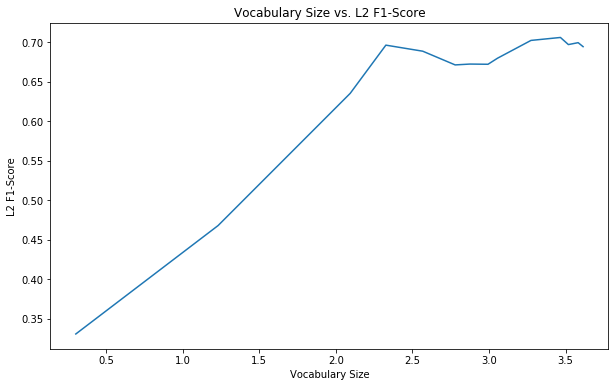

In [10]:
def P6():
  # Keep this random seed here to make comparison easier.
  np.random.seed(0)

  cv = CountVectorizer()
  cv_train_data = cv.fit_transform(train_data)
  cv_dev_data = cv.transform(dev_data)

  c_list = [0.001, 0.01, 0.05, 0.1, 0.2, 0.35, 0.5, 0.75, 1.0, 2.5, 6.0, 10, 15, 20]
  
  l1_coefs, l2_coefs, f1_scores, vocab_sizes, new_vocab, new_vocab_indexes, f1_scoresl1 = [], [], [], [], [], [], []
  # test = np.array([])

  for c, i in zip(c_list, range(len(c_list))):
    # Logistic regression model with L1 penalty for mutliple values of C
    log_clf01 = LogisticRegression(penalty='l1', C=c, solver='liblinear', multi_class='auto', tol=0.015)
    log_clf01.fit(cv_train_data, train_labels) # Train model
    predictions = log_clf01.predict(cv_dev_data) # predict
    l1_coefs.append(log_clf01.coef_) # Extract coefficient values
    vocab_sizes.append(np.count_nonzero(np.abs(l1_coefs[i]).sum(axis=0))) # Sum the absolute value of four models respective coefficients. Count all nonzero coefs
    new_vocab_indexes.append(np.abs(l1_coefs[i]).sum(axis=0).nonzero()[0].tolist())  # Load the index of nonzero coefficients into the list.
    new_vocab.append(np.array(cv.get_feature_names())[new_vocab_indexes[i]]) # Get new vocab by extracting features using the indexes of nonzero coefs.
    f1_scoresl1.append(metrics.f1_score(dev_labels, predictions, average='weighted')) # Calculate f1-score and add to list



  for i in range(len(c_list)):
    # Create new count vectorizer
    cv02 = CountVectorizer(vocabulary=new_vocab[i].tolist()) 
    cv02_train_data = cv02.fit_transform(train_data) 
    cv02_dev_data = cv02.transform(dev_data)
    # Logistic regression model using reduced vocab from L1 penalty logistic regression model
    log_clf02 = LogisticRegression(penalty='l2', C=0.5, solver='liblinear', multi_class='auto', tol=0.015)
    log_clf02.fit(cv02_train_data, train_labels) # fit
    predictions = log_clf02.predict(cv02_dev_data) # predict
    f1_scores.append(metrics.f1_score(dev_labels, predictions, average='weighted')) # Calculate f1-score and add to list

  # Output L1 regularization value, vocabulary size, f1-score from L2 regularization model
  df = pd.DataFrame(data=[vocab_sizes, f1_scores]).T.round(4)
  df.index = c_list
  df.columns=['Vocab Size', 'L2 F1-Score']
  df.index.name = 'L1 Reg Value'
  display(df)
  print("\n")

  log_vocab = []

  for num in vocab_sizes:
    log_vocab.append(math.log10(num))


  # Output vocabulary size vs. f1-score from L2 regularization model
  plt.figure(figsize=(10,6))
  plt.plot(log_vocab, f1_scores)
  plt.title("Vocabulary Size vs. L2 F1-Score")
  plt.xlabel("Vocabulary Size")
  plt.ylabel("L2 F1-Score")
  plt.show()

P6()

ANSWER:  
The models using reduced vocabulary generally perform worse than the models with full vocabulary.  Let's compare two examples:  C=0.5 for the full vocabulary model has an f1-score of 0.7085, while the reduced vocabulary model has an f1-score of 0.6715 and a vocabulary size of 739.  C=1 for the full vocabulary model has an f1-score of 0.6944, while the reduced vocabulary model has an f1-score of 0.6802 and a vocabulary size of 1169.  This goes to show that a model using 95 - 97% less words can be fairly close in performance.  It is worth noting that as the vocabulary increases, the gap between performance decreases.

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [11]:
def P7():
  # convert a collection of raw documents to a matrix of TF-IDF features.
  tv = TfidfVectorizer()
  tv_train_data = tv.fit_transform(train_data)
  tv_dev_data = tv.transform(dev_data)

  # use a logistic regression classifier to make predictions 
  log_clf_01 = LogisticRegression(C=100, solver='liblinear', multi_class='auto')
  log_clf_01.fit(tv_train_data, train_labels) # fit model
  predictions_01 = log_clf_01.predict(tv_dev_data) # predict 
  probs_01 = log_clf_01.predict_proba(tv_dev_data) # store predicted label probabilities
  f1_score_01 = metrics.f1_score(dev_labels, predictions_01, average='weighted') # calculate f1-score

  # convert text documents to a matrix of token counts
  cv = CountVectorizer()
  cv_train_data = cv.fit_transform(train_data)
  cv_dev_data = cv.transform(dev_data)

  log_clf_02 = LogisticRegression(C=100, solver='liblinear', multi_class='auto')
  log_clf_02.fit(cv_train_data, train_labels) # fit model
  predictions_02 = log_clf_02.predict(cv_dev_data) # predict
  probs_02 = log_clf_02.predict_proba(cv_dev_data) # store predicted label probabilities 
  f1_score_02 = metrics.f1_score(dev_labels, predictions_02, average='weighted') # calculate f1-score

  r_ratios = []

  # find max R ratios
  # iterate through probabilities
  for i in range(len(probs_01)):
    max_prob_predict = probs_01[i].max() # find the max probability
    prob_actual = probs_01[i][dev_labels[i]] # find the actual label probability
    r_ratios.append(max_prob_predict/prob_actual) # calculate the R ratio
  top_indexes = np.array(r_ratios).argsort()[-3:] # find the top 3 largest R ratios

  top_r_ratios = sorted(r_ratios, reverse=True)[0:3] # rearrange the R ratios to descending order

  print("The f1-score for the CountVectorizer is:", round(f1_score_02,4),"\n")
  print("The f1-score for the TfidVectorizer is:", round(f1_score_01,4),"\n")
  print("The three documents with the highest R Ratio are:\n")
  for i in reversed(top_indexes):
    print("Document {}".format(i))
    print("R Ratio =",round(r_ratios[i],2))
    print("Actual Label:",newsgroups_train.target_names[dev_labels[i]])  
    print("Predicted Label:", newsgroups_train.target_names[predictions_01[i]])
    print("\n",dev_data[i])
    print('\n')

P7()

The f1-score for the CountVectorizer is: 0.6829 

The f1-score for the TfidVectorizer is: 0.7598 

The three documents with the highest R Ratio are:

Document 215
R Ratio = 929.36
Actual Label: talk.religion.misc
Predicted Label: comp.graphics

 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual

ANSWER:  
The TfidVectorizer scores better, at 0.7598, than the CountVectorizer, which scores 0.6824.  Recall that the CountVectorizer creates a matrix of token counts from text documents.  It is a basic count of the number of times each token (word) appears.  The TfidVectorizer, on the other hand, uses a weighting of term-frequency times inverse document-frequency.  This differentiating characteristic does not allow tokens that appear frequently but provide little meaning to overshadow the frequency of rarer yet more significant features.

The R ratio divides the maximum probability predicted for each text document by the probability of the actual label for that text document.  If the text document is classified correctly, the R ratio is one, which is the lowest value for the R ratio.  If the text document is classified incorrectly, the R ratio will be greater than one. Suppose the actual label probability is less than but close to the maximum probability; in this case, the R ratio will be greater than one but smaller than if the correct label probability was much smaller than the maximum probability.

From the examples we looked at, a high R ratio describes a scenario where the document is incorrectly classified because the meaningful tokens in the document appeared less frequently than several other words that were good/decent predictors of another topic.  Document 665, for example, is actually labeled talk.religion.misc but classified as comp.graphics because "Moron" is mention once while tokens like "ftp", "site, "internet" take away from the context.  

One suggestion to address the religion topic's misclassification is using a trigram vectorizer.  This may cause the classifier to recognize the phrase "book of moron" as highly associated with the topic of religion.










### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.

In [12]:
def P8():
    # convert a collection of raw documents to a trigram matrix of TF-IDF features
    tv = TfidfVectorizer(ngram_range=(3,3))
    tv_train_data = tv.fit_transform(train_data)
    tv_dev_data = tv.transform(dev_data)

    # use a logistic regression classifier to make predictions 
    log_clf_01 = LogisticRegression(C=100, solver='liblinear', multi_class='auto')
    log_clf_01.fit(tv_train_data, train_labels) # fit model
    predictions_01 = log_clf_01.predict(tv_dev_data) # predict 
    probs_01 = log_clf_01.predict_proba(tv_dev_data) # store predicted label probabilities
    f1_score_01 = metrics.f1_score(dev_labels, predictions_01, average='weighted') # calculate f1-score
    print("The f1-score of the tri-gram TfidVectorizer is:", round(f1_score_01,4),"\n")

    document_list = [215, 665, 607]

    for doc in document_list:
        print("The R ratio for document{} is:".format(doc), round(probs_01[doc].max()/probs_01[doc][dev_labels[doc]], 2))
        
P8()


The f1-score of the tri-gram TfidVectorizer is: 0.6112 

The R ratio for document215 is: 37.95
The R ratio for document665 is: 10.45
The R ratio for document607 is: 5.77


ANSWER:  
The trigram vectorizer reduced the R ratio of the top 3 highest from Part 7.  However, it scored lower.